<a href="https://colab.research.google.com/github/ArnyWu/DeepGenerativeModels_HW2/blob/main/%E6%B7%B1%E5%BA%A6%E7%94%9F%E6%88%90%E5%AD%B8%E7%BF%92HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torchmetrics
!pip install torchmetrics[image]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 29.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm

from torchmetrics.image.fid import FrechetInceptionDistance
from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 參數
batch_size = 128
epochs = 150
lr = 1e-3
hidden_dim = 400
latent_dim = 20
patience = 10

# MNIST dataset
transform = transforms.ToTensor()
full_train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# 拆分 train / valid
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# VAE 定義
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        # Encoder
        self.fc1 = nn.Linear(28*28, hidden_dim)
        self.fc21 = nn.Linear(hidden_dim, latent_dim)  # μ
        self.fc22 = nn.Linear(hidden_dim, latent_dim)  # log σ²
        # Decoder
        self.fc3 = nn.Linear(latent_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss = BCE + KLD
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# 訓練
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses, valid_losses = [], []
best_val_loss = float("inf")
early_stop_counter = 0
best_model_path = "vae_best.pth"

total_start = time.time()
for epoch in range(1, epochs+1):
    start_time = time.time()
    # --- Train ---
    model.train()
    train_loss = 0
    for data, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(avg_train_loss)

    # --- Validation ---
    model.eval()
    valid_loss = 0
    with torch.no_grad():
        for data, _ in valid_loader:
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar)
            valid_loss += loss.item()
    avg_val_loss = valid_loss / len(valid_loader.dataset)
    valid_losses.append(avg_val_loss)

    epoch_time = time.time() - start_time
    print(f"Epoch {epoch}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Time: {epoch_time:.2f} sec")

    # Save best model
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print("Saved Best Model")
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 480kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.46MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.4MB/s]
Epoch 1/150: 100%|██████████| 375/375 [00:06<00:00, 59.36it/s]


Epoch 1, Train Loss: 173.3316, Val Loss: 135.1546, Time: 7.84 sec
Saved Best Model


Epoch 2/150: 100%|██████████| 375/375 [00:05<00:00, 64.88it/s]


Epoch 2, Train Loss: 126.4194, Val Loss: 120.4201, Time: 6.95 sec
Saved Best Model


Epoch 3/150: 100%|██████████| 375/375 [00:06<00:00, 60.76it/s]


Epoch 3, Train Loss: 117.4791, Val Loss: 115.1807, Time: 7.35 sec
Saved Best Model


Epoch 4/150: 100%|██████████| 375/375 [00:05<00:00, 67.74it/s]


Epoch 4, Train Loss: 113.8059, Val Loss: 112.6775, Time: 6.72 sec
Saved Best Model


Epoch 5/150: 100%|██████████| 375/375 [00:06<00:00, 60.79it/s]


Epoch 5, Train Loss: 111.5844, Val Loss: 110.8384, Time: 7.36 sec
Saved Best Model


Epoch 6/150: 100%|██████████| 375/375 [00:05<00:00, 67.92it/s]


Epoch 6, Train Loss: 110.1876, Val Loss: 109.9411, Time: 6.84 sec
Saved Best Model


Epoch 7/150: 100%|██████████| 375/375 [00:06<00:00, 61.97it/s]


Epoch 7, Train Loss: 109.1366, Val Loss: 109.1149, Time: 7.24 sec
Saved Best Model


Epoch 8/150: 100%|██████████| 375/375 [00:06<00:00, 61.97it/s]


Epoch 8, Train Loss: 108.2785, Val Loss: 108.3165, Time: 7.39 sec
Saved Best Model


Epoch 9/150: 100%|██████████| 375/375 [00:06<00:00, 58.51it/s]


Epoch 9, Train Loss: 107.7133, Val Loss: 107.7784, Time: 7.60 sec
Saved Best Model


Epoch 10/150: 100%|██████████| 375/375 [00:06<00:00, 61.56it/s]


Epoch 10, Train Loss: 107.1420, Val Loss: 107.4329, Time: 7.29 sec
Saved Best Model


Epoch 11/150: 100%|██████████| 375/375 [00:05<00:00, 67.65it/s]


Epoch 11, Train Loss: 106.7220, Val Loss: 106.9484, Time: 6.95 sec
Saved Best Model


Epoch 12/150: 100%|██████████| 375/375 [00:05<00:00, 62.52it/s]


Epoch 12, Train Loss: 106.3486, Val Loss: 106.6748, Time: 7.17 sec
Saved Best Model


Epoch 13/150: 100%|██████████| 375/375 [00:06<00:00, 60.50it/s]


Epoch 13, Train Loss: 106.0031, Val Loss: 106.5907, Time: 7.37 sec
Saved Best Model


Epoch 14/150: 100%|██████████| 375/375 [00:05<00:00, 68.16it/s]


Epoch 14, Train Loss: 105.7548, Val Loss: 106.1742, Time: 6.67 sec
Saved Best Model


Epoch 15/150: 100%|██████████| 375/375 [00:06<00:00, 60.65it/s]


Epoch 15, Train Loss: 105.4767, Val Loss: 106.0330, Time: 7.36 sec
Saved Best Model


Epoch 16/150: 100%|██████████| 375/375 [00:05<00:00, 67.80it/s]


Epoch 16, Train Loss: 105.2755, Val Loss: 105.9298, Time: 6.70 sec
Saved Best Model


Epoch 17/150: 100%|██████████| 375/375 [00:06<00:00, 61.14it/s]


Epoch 17, Train Loss: 105.0795, Val Loss: 105.6814, Time: 7.30 sec
Saved Best Model


Epoch 18/150: 100%|██████████| 375/375 [00:05<00:00, 63.98it/s]


Epoch 18, Train Loss: 104.8470, Val Loss: 105.5392, Time: 7.40 sec
Saved Best Model


Epoch 19/150: 100%|██████████| 375/375 [00:05<00:00, 67.07it/s]


Epoch 19, Train Loss: 104.6968, Val Loss: 105.1514, Time: 6.76 sec
Saved Best Model


Epoch 20/150: 100%|██████████| 375/375 [00:06<00:00, 60.85it/s]


Epoch 20, Train Loss: 104.5384, Val Loss: 105.1558, Time: 7.37 sec


Epoch 21/150: 100%|██████████| 375/375 [00:05<00:00, 68.24it/s]


Epoch 21, Train Loss: 104.4164, Val Loss: 104.9649, Time: 6.67 sec
Saved Best Model


Epoch 22/150: 100%|██████████| 375/375 [00:06<00:00, 61.13it/s]


Epoch 22, Train Loss: 104.2801, Val Loss: 104.8275, Time: 7.31 sec
Saved Best Model


Epoch 23/150: 100%|██████████| 375/375 [00:05<00:00, 66.77it/s]


Epoch 23, Train Loss: 104.1665, Val Loss: 104.7161, Time: 7.29 sec
Saved Best Model


Epoch 24/150: 100%|██████████| 375/375 [00:05<00:00, 66.89it/s]


Epoch 24, Train Loss: 103.9607, Val Loss: 104.5492, Time: 6.77 sec
Saved Best Model


Epoch 25/150: 100%|██████████| 375/375 [00:06<00:00, 60.61it/s]


Epoch 25, Train Loss: 103.8963, Val Loss: 104.5691, Time: 7.36 sec


Epoch 26/150: 100%|██████████| 375/375 [00:05<00:00, 68.08it/s]


Epoch 26, Train Loss: 103.7321, Val Loss: 104.4538, Time: 6.75 sec
Saved Best Model


Epoch 27/150: 100%|██████████| 375/375 [00:06<00:00, 61.36it/s]


Epoch 27, Train Loss: 103.6603, Val Loss: 104.4199, Time: 7.31 sec
Saved Best Model


Epoch 28/150: 100%|██████████| 375/375 [00:05<00:00, 68.38it/s]


Epoch 28, Train Loss: 103.5182, Val Loss: 104.2912, Time: 6.99 sec
Saved Best Model


Epoch 29/150: 100%|██████████| 375/375 [00:05<00:00, 63.65it/s]


Epoch 29, Train Loss: 103.4706, Val Loss: 104.4284, Time: 7.07 sec


Epoch 30/150: 100%|██████████| 375/375 [00:06<00:00, 59.51it/s]


Epoch 30, Train Loss: 103.3496, Val Loss: 104.1160, Time: 7.48 sec
Saved Best Model


Epoch 31/150: 100%|██████████| 375/375 [00:05<00:00, 67.00it/s]


Epoch 31, Train Loss: 103.2637, Val Loss: 104.1166, Time: 6.77 sec


Epoch 32/150: 100%|██████████| 375/375 [00:06<00:00, 60.93it/s]


Epoch 32, Train Loss: 103.1618, Val Loss: 104.0071, Time: 7.33 sec
Saved Best Model


Epoch 33/150: 100%|██████████| 375/375 [00:05<00:00, 67.58it/s]


Epoch 33, Train Loss: 103.1123, Val Loss: 103.8762, Time: 6.91 sec
Saved Best Model


Epoch 34/150: 100%|██████████| 375/375 [00:05<00:00, 63.11it/s]


Epoch 34, Train Loss: 103.0087, Val Loss: 103.9317, Time: 7.10 sec


Epoch 35/150: 100%|██████████| 375/375 [00:05<00:00, 63.02it/s]


Epoch 35, Train Loss: 102.9594, Val Loss: 103.7991, Time: 7.34 sec
Saved Best Model


Epoch 36/150: 100%|██████████| 375/375 [00:05<00:00, 66.84it/s]


Epoch 36, Train Loss: 102.8668, Val Loss: 103.8135, Time: 6.78 sec


Epoch 37/150: 100%|██████████| 375/375 [00:06<00:00, 61.18it/s]


Epoch 37, Train Loss: 102.7971, Val Loss: 103.7533, Time: 7.34 sec
Saved Best Model


Epoch 38/150: 100%|██████████| 375/375 [00:05<00:00, 66.73it/s]


Epoch 38, Train Loss: 102.7289, Val Loss: 103.7671, Time: 6.81 sec


Epoch 39/150: 100%|██████████| 375/375 [00:06<00:00, 60.71it/s]


Epoch 39, Train Loss: 102.6942, Val Loss: 103.6626, Time: 7.33 sec
Saved Best Model


Epoch 40/150: 100%|██████████| 375/375 [00:05<00:00, 64.32it/s]


Epoch 40, Train Loss: 102.6305, Val Loss: 103.5141, Time: 7.43 sec
Saved Best Model


Epoch 41/150: 100%|██████████| 375/375 [00:05<00:00, 68.13it/s]


Epoch 41, Train Loss: 102.5573, Val Loss: 103.5239, Time: 6.68 sec


Epoch 42/150: 100%|██████████| 375/375 [00:06<00:00, 60.95it/s]


Epoch 42, Train Loss: 102.4541, Val Loss: 103.4832, Time: 7.34 sec
Saved Best Model


Epoch 43/150: 100%|██████████| 375/375 [00:05<00:00, 67.85it/s]


Epoch 43, Train Loss: 102.4282, Val Loss: 103.3947, Time: 6.71 sec
Saved Best Model


Epoch 44/150: 100%|██████████| 375/375 [00:06<00:00, 61.43it/s]


Epoch 44, Train Loss: 102.3835, Val Loss: 103.3119, Time: 7.26 sec
Saved Best Model


Epoch 45/150: 100%|██████████| 375/375 [00:05<00:00, 67.70it/s]


Epoch 45, Train Loss: 102.3048, Val Loss: 103.2981, Time: 7.14 sec
Saved Best Model


Epoch 46/150: 100%|██████████| 375/375 [00:05<00:00, 65.38it/s]


Epoch 46, Train Loss: 102.2699, Val Loss: 103.2685, Time: 6.90 sec
Saved Best Model


Epoch 47/150: 100%|██████████| 375/375 [00:06<00:00, 60.56it/s]


Epoch 47, Train Loss: 102.2022, Val Loss: 103.3988, Time: 7.38 sec


Epoch 48/150: 100%|██████████| 375/375 [00:05<00:00, 68.27it/s]


Epoch 48, Train Loss: 102.2332, Val Loss: 103.2729, Time: 6.65 sec


Epoch 49/150: 100%|██████████| 375/375 [00:06<00:00, 61.04it/s]


Epoch 49, Train Loss: 102.1293, Val Loss: 103.2139, Time: 7.30 sec
Saved Best Model


Epoch 50/150: 100%|██████████| 375/375 [00:05<00:00, 67.60it/s]


Epoch 50, Train Loss: 102.1058, Val Loss: 103.0698, Time: 6.92 sec
Saved Best Model


Epoch 51/150: 100%|██████████| 375/375 [00:05<00:00, 63.30it/s]


Epoch 51, Train Loss: 102.0864, Val Loss: 102.9858, Time: 7.09 sec
Saved Best Model


Epoch 52/150: 100%|██████████| 375/375 [00:05<00:00, 62.62it/s]


Epoch 52, Train Loss: 101.9879, Val Loss: 103.0152, Time: 7.30 sec


Epoch 53/150: 100%|██████████| 375/375 [00:05<00:00, 68.19it/s]


Epoch 53, Train Loss: 101.9540, Val Loss: 103.0190, Time: 6.69 sec


Epoch 54/150: 100%|██████████| 375/375 [00:06<00:00, 61.39it/s]


Epoch 54, Train Loss: 101.8775, Val Loss: 103.0302, Time: 7.32 sec


Epoch 55/150: 100%|██████████| 375/375 [00:05<00:00, 67.49it/s]


Epoch 55, Train Loss: 101.8535, Val Loss: 103.0005, Time: 6.73 sec


Epoch 56/150: 100%|██████████| 375/375 [00:06<00:00, 61.11it/s]


Epoch 56, Train Loss: 101.8414, Val Loss: 103.0036, Time: 7.31 sec


Epoch 57/150: 100%|██████████| 375/375 [00:05<00:00, 65.63it/s]


Epoch 57, Train Loss: 101.7752, Val Loss: 102.9625, Time: 7.31 sec
Saved Best Model


Epoch 58/150: 100%|██████████| 375/375 [00:05<00:00, 68.28it/s]


Epoch 58, Train Loss: 101.8044, Val Loss: 102.8339, Time: 6.66 sec
Saved Best Model


Epoch 59/150: 100%|██████████| 375/375 [00:06<00:00, 60.87it/s]


Epoch 59, Train Loss: 101.7117, Val Loss: 102.9503, Time: 7.34 sec


Epoch 60/150: 100%|██████████| 375/375 [00:05<00:00, 68.01it/s]


Epoch 60, Train Loss: 101.7037, Val Loss: 102.8199, Time: 6.68 sec
Saved Best Model


Epoch 61/150: 100%|██████████| 375/375 [00:06<00:00, 60.98it/s]


Epoch 61, Train Loss: 101.6712, Val Loss: 102.8211, Time: 7.31 sec


Epoch 62/150: 100%|██████████| 375/375 [00:05<00:00, 67.29it/s]


Epoch 62, Train Loss: 101.6010, Val Loss: 102.7600, Time: 7.14 sec
Saved Best Model


Epoch 63/150: 100%|██████████| 375/375 [00:05<00:00, 64.54it/s]


Epoch 63, Train Loss: 101.6349, Val Loss: 102.6691, Time: 6.97 sec
Saved Best Model


Epoch 64/150: 100%|██████████| 375/375 [00:06<00:00, 60.31it/s]


Epoch 64, Train Loss: 101.5857, Val Loss: 102.5432, Time: 7.40 sec
Saved Best Model


Epoch 65/150: 100%|██████████| 375/375 [00:05<00:00, 68.55it/s]


Epoch 65, Train Loss: 101.5339, Val Loss: 102.5635, Time: 6.64 sec


Epoch 66/150: 100%|██████████| 375/375 [00:06<00:00, 60.47it/s]


Epoch 66, Train Loss: 101.4688, Val Loss: 102.6704, Time: 7.39 sec


Epoch 67/150: 100%|██████████| 375/375 [00:05<00:00, 67.59it/s]


Epoch 67, Train Loss: 101.5131, Val Loss: 102.7129, Time: 6.94 sec


Epoch 68/150: 100%|██████████| 375/375 [00:05<00:00, 62.84it/s]


Epoch 68, Train Loss: 101.4188, Val Loss: 102.6240, Time: 7.14 sec


Epoch 69/150: 100%|██████████| 375/375 [00:06<00:00, 61.16it/s]


Epoch 69, Train Loss: 101.4017, Val Loss: 102.5464, Time: 7.31 sec


Epoch 70/150: 100%|██████████| 375/375 [00:05<00:00, 67.93it/s]


Epoch 70, Train Loss: 101.3881, Val Loss: 102.4289, Time: 6.72 sec
Saved Best Model


Epoch 71/150: 100%|██████████| 375/375 [00:06<00:00, 60.62it/s]


Epoch 71, Train Loss: 101.3292, Val Loss: 102.6125, Time: 7.37 sec


Epoch 72/150: 100%|██████████| 375/375 [00:05<00:00, 68.35it/s]


Epoch 72, Train Loss: 101.3006, Val Loss: 102.7457, Time: 6.67 sec


Epoch 73/150: 100%|██████████| 375/375 [00:06<00:00, 60.19it/s]


Epoch 73, Train Loss: 101.2723, Val Loss: 102.5314, Time: 7.39 sec


Epoch 74/150: 100%|██████████| 375/375 [00:05<00:00, 63.18it/s]


Epoch 74, Train Loss: 101.2670, Val Loss: 102.5134, Time: 7.50 sec


Epoch 75/150: 100%|██████████| 375/375 [00:05<00:00, 67.66it/s]


Epoch 75, Train Loss: 101.2709, Val Loss: 102.3960, Time: 6.72 sec
Saved Best Model


Epoch 76/150: 100%|██████████| 375/375 [00:06<00:00, 60.40it/s]


Epoch 76, Train Loss: 101.1861, Val Loss: 102.3781, Time: 7.39 sec
Saved Best Model


Epoch 77/150: 100%|██████████| 375/375 [00:05<00:00, 67.36it/s]


Epoch 77, Train Loss: 101.2025, Val Loss: 102.4263, Time: 6.74 sec


Epoch 78/150: 100%|██████████| 375/375 [00:06<00:00, 61.18it/s]


Epoch 78, Train Loss: 101.1704, Val Loss: 102.4522, Time: 7.30 sec


Epoch 79/150: 100%|██████████| 375/375 [00:05<00:00, 66.21it/s]


Epoch 79, Train Loss: 101.1504, Val Loss: 102.4416, Time: 7.36 sec


Epoch 80/150: 100%|██████████| 375/375 [00:05<00:00, 67.64it/s]


Epoch 80, Train Loss: 101.1149, Val Loss: 102.3415, Time: 6.74 sec
Saved Best Model


Epoch 81/150: 100%|██████████| 375/375 [00:06<00:00, 60.72it/s]


Epoch 81, Train Loss: 101.0739, Val Loss: 102.3094, Time: 7.36 sec
Saved Best Model


Epoch 82/150: 100%|██████████| 375/375 [00:05<00:00, 67.53it/s]


Epoch 82, Train Loss: 101.0681, Val Loss: 102.3372, Time: 6.73 sec


Epoch 83/150: 100%|██████████| 375/375 [00:06<00:00, 60.60it/s]


Epoch 83, Train Loss: 101.0135, Val Loss: 102.2675, Time: 7.37 sec
Saved Best Model


Epoch 84/150: 100%|██████████| 375/375 [00:05<00:00, 67.91it/s]


Epoch 84, Train Loss: 101.0551, Val Loss: 102.4480, Time: 7.10 sec


Epoch 85/150: 100%|██████████| 375/375 [00:05<00:00, 65.29it/s]


Epoch 85, Train Loss: 100.9474, Val Loss: 102.1813, Time: 6.94 sec
Saved Best Model


Epoch 86/150: 100%|██████████| 375/375 [00:06<00:00, 60.24it/s]


Epoch 86, Train Loss: 100.9919, Val Loss: 102.2207, Time: 7.41 sec


Epoch 87/150: 100%|██████████| 375/375 [00:05<00:00, 67.25it/s]


Epoch 87, Train Loss: 100.9285, Val Loss: 102.2684, Time: 6.77 sec


Epoch 88/150: 100%|██████████| 375/375 [00:06<00:00, 60.91it/s]


Epoch 88, Train Loss: 100.9371, Val Loss: 102.0778, Time: 7.35 sec
Saved Best Model


Epoch 89/150: 100%|██████████| 375/375 [00:05<00:00, 67.23it/s]


Epoch 89, Train Loss: 100.9020, Val Loss: 102.2556, Time: 6.99 sec


Epoch 90/150: 100%|██████████| 375/375 [00:05<00:00, 62.74it/s]


Epoch 90, Train Loss: 100.8811, Val Loss: 102.1034, Time: 7.15 sec


Epoch 91/150: 100%|██████████| 375/375 [00:06<00:00, 59.66it/s]


Epoch 91, Train Loss: 100.8453, Val Loss: 102.1730, Time: 7.95 sec


Epoch 92/150: 100%|██████████| 375/375 [00:05<00:00, 66.15it/s]


Epoch 92, Train Loss: 100.8321, Val Loss: 102.0660, Time: 6.86 sec
Saved Best Model


Epoch 93/150: 100%|██████████| 375/375 [00:06<00:00, 60.25it/s]


Epoch 93, Train Loss: 100.7904, Val Loss: 102.2230, Time: 7.41 sec


Epoch 94/150: 100%|██████████| 375/375 [00:05<00:00, 67.80it/s]


Epoch 94, Train Loss: 100.8292, Val Loss: 102.1332, Time: 7.04 sec


Epoch 95/150: 100%|██████████| 375/375 [00:05<00:00, 63.67it/s]


Epoch 95, Train Loss: 100.7672, Val Loss: 102.0772, Time: 7.06 sec


Epoch 96/150: 100%|██████████| 375/375 [00:06<00:00, 60.38it/s]


Epoch 96, Train Loss: 100.7797, Val Loss: 102.2084, Time: 7.39 sec


Epoch 97/150: 100%|██████████| 375/375 [00:05<00:00, 67.15it/s]


Epoch 97, Train Loss: 100.7338, Val Loss: 102.1050, Time: 6.75 sec


Epoch 98/150: 100%|██████████| 375/375 [00:06<00:00, 60.18it/s]


Epoch 98, Train Loss: 100.7452, Val Loss: 102.0408, Time: 7.41 sec
Saved Best Model


Epoch 99/150: 100%|██████████| 375/375 [00:05<00:00, 67.82it/s]


Epoch 99, Train Loss: 100.7241, Val Loss: 101.9877, Time: 6.84 sec
Saved Best Model


Epoch 100/150: 100%|██████████| 375/375 [00:06<00:00, 61.82it/s]


Epoch 100, Train Loss: 100.6977, Val Loss: 102.0170, Time: 7.24 sec


Epoch 101/150: 100%|██████████| 375/375 [00:06<00:00, 62.20it/s]


Epoch 101, Train Loss: 100.7030, Val Loss: 101.9636, Time: 7.40 sec
Saved Best Model


Epoch 102/150: 100%|██████████| 375/375 [00:05<00:00, 67.80it/s]


Epoch 102, Train Loss: 100.6572, Val Loss: 101.8278, Time: 6.70 sec
Saved Best Model


Epoch 103/150: 100%|██████████| 375/375 [00:06<00:00, 60.75it/s]


Epoch 103, Train Loss: 100.6389, Val Loss: 101.9355, Time: 7.35 sec


Epoch 104/150: 100%|██████████| 375/375 [00:05<00:00, 67.40it/s]


Epoch 104, Train Loss: 100.6750, Val Loss: 101.8633, Time: 6.75 sec


Epoch 105/150: 100%|██████████| 375/375 [00:06<00:00, 60.43it/s]


Epoch 105, Train Loss: 100.6070, Val Loss: 102.0068, Time: 7.39 sec


Epoch 106/150: 100%|██████████| 375/375 [00:05<00:00, 64.95it/s]


Epoch 106, Train Loss: 100.6066, Val Loss: 101.8864, Time: 7.36 sec


Epoch 107/150: 100%|██████████| 375/375 [00:05<00:00, 67.24it/s]


Epoch 107, Train Loss: 100.5683, Val Loss: 101.9021, Time: 6.75 sec


Epoch 108/150: 100%|██████████| 375/375 [00:06<00:00, 60.22it/s]


Epoch 108, Train Loss: 100.5824, Val Loss: 102.0815, Time: 7.42 sec


Epoch 109/150: 100%|██████████| 375/375 [00:05<00:00, 67.67it/s]


Epoch 109, Train Loss: 100.5638, Val Loss: 101.9148, Time: 6.76 sec


Epoch 110/150: 100%|██████████| 375/375 [00:06<00:00, 60.94it/s]


Epoch 110, Train Loss: 100.5347, Val Loss: 102.0017, Time: 7.34 sec


Epoch 111/150: 100%|██████████| 375/375 [00:05<00:00, 67.32it/s]


Epoch 111, Train Loss: 100.4916, Val Loss: 102.0001, Time: 7.26 sec


Epoch 112/150: 100%|██████████| 375/375 [00:05<00:00, 67.02it/s]


Epoch 112, Train Loss: 100.5048, Val Loss: 101.7646, Time: 6.78 sec
Saved Best Model


Epoch 113/150: 100%|██████████| 375/375 [00:06<00:00, 60.86it/s]


Epoch 113, Train Loss: 100.5108, Val Loss: 101.8344, Time: 7.34 sec


Epoch 114/150: 100%|██████████| 375/375 [00:05<00:00, 67.02it/s]


Epoch 114, Train Loss: 100.4439, Val Loss: 101.9338, Time: 6.79 sec


Epoch 115/150: 100%|██████████| 375/375 [00:06<00:00, 60.56it/s]


Epoch 115, Train Loss: 100.5156, Val Loss: 101.7212, Time: 7.36 sec
Saved Best Model


Epoch 116/150: 100%|██████████| 375/375 [00:05<00:00, 67.27it/s]


Epoch 116, Train Loss: 100.4382, Val Loss: 101.7728, Time: 7.09 sec


Epoch 117/150: 100%|██████████| 375/375 [00:05<00:00, 63.01it/s]


Epoch 117, Train Loss: 100.4304, Val Loss: 101.8299, Time: 7.11 sec


Epoch 118/150: 100%|██████████| 375/375 [00:06<00:00, 60.06it/s]


Epoch 118, Train Loss: 100.4468, Val Loss: 101.7745, Time: 7.44 sec


Epoch 119/150: 100%|██████████| 375/375 [00:05<00:00, 67.44it/s]


Epoch 119, Train Loss: 100.4365, Val Loss: 101.8384, Time: 6.72 sec


Epoch 120/150: 100%|██████████| 375/375 [00:10<00:00, 36.36it/s]


Epoch 120, Train Loss: 100.4118, Val Loss: 101.8235, Time: 11.53 sec


Epoch 121/150: 100%|██████████| 375/375 [00:06<00:00, 61.08it/s]


Epoch 121, Train Loss: 100.3942, Val Loss: 101.8852, Time: 7.35 sec


Epoch 122/150: 100%|██████████| 375/375 [00:05<00:00, 67.50it/s]


Epoch 122, Train Loss: 100.3927, Val Loss: 101.8782, Time: 6.74 sec


Epoch 123/150: 100%|██████████| 375/375 [00:06<00:00, 60.94it/s]


Epoch 123, Train Loss: 100.3521, Val Loss: 101.8193, Time: 7.34 sec


Epoch 124/150: 100%|██████████| 375/375 [00:05<00:00, 66.74it/s]


Epoch 124, Train Loss: 100.3445, Val Loss: 101.8418, Time: 7.35 sec


Epoch 125/150: 100%|██████████| 375/375 [00:05<00:00, 67.35it/s]


Epoch 125, Train Loss: 100.3577, Val Loss: 101.6427, Time: 6.74 sec
Saved Best Model


Epoch 126/150: 100%|██████████| 375/375 [00:06<00:00, 60.62it/s]


Epoch 126, Train Loss: 100.3361, Val Loss: 101.6943, Time: 7.36 sec


Epoch 127/150: 100%|██████████| 375/375 [00:06<00:00, 60.58it/s]


Epoch 127, Train Loss: 100.2639, Val Loss: 101.8279, Time: 7.36 sec


Epoch 128/150: 100%|██████████| 375/375 [00:06<00:00, 60.56it/s]


Epoch 128, Train Loss: 100.2838, Val Loss: 101.7829, Time: 7.37 sec


Epoch 129/150: 100%|██████████| 375/375 [00:05<00:00, 66.29it/s]


Epoch 129, Train Loss: 100.2857, Val Loss: 101.6839, Time: 7.29 sec


Epoch 130/150: 100%|██████████| 375/375 [00:05<00:00, 66.38it/s]


Epoch 130, Train Loss: 100.2758, Val Loss: 101.7706, Time: 6.85 sec


Epoch 131/150: 100%|██████████| 375/375 [00:06<00:00, 60.61it/s]


Epoch 131, Train Loss: 100.2329, Val Loss: 101.8838, Time: 7.36 sec


Epoch 132/150: 100%|██████████| 375/375 [00:05<00:00, 68.08it/s]


Epoch 132, Train Loss: 100.2404, Val Loss: 101.6099, Time: 6.71 sec
Saved Best Model


Epoch 133/150: 100%|██████████| 375/375 [00:06<00:00, 59.98it/s]


Epoch 133, Train Loss: 100.2573, Val Loss: 101.7844, Time: 7.43 sec


Epoch 134/150: 100%|██████████| 375/375 [00:05<00:00, 67.04it/s]


Epoch 134, Train Loss: 100.2410, Val Loss: 101.6544, Time: 7.22 sec


Epoch 135/150: 100%|██████████| 375/375 [00:05<00:00, 65.77it/s]


Epoch 135, Train Loss: 100.2003, Val Loss: 101.6059, Time: 6.89 sec
Saved Best Model


Epoch 136/150: 100%|██████████| 375/375 [00:06<00:00, 60.58it/s]


Epoch 136, Train Loss: 100.1827, Val Loss: 101.6791, Time: 7.37 sec


Epoch 137/150: 100%|██████████| 375/375 [00:05<00:00, 66.75it/s]


Epoch 137, Train Loss: 100.1886, Val Loss: 101.5146, Time: 6.80 sec
Saved Best Model


Epoch 138/150: 100%|██████████| 375/375 [00:06<00:00, 60.08it/s]


Epoch 138, Train Loss: 100.1778, Val Loss: 101.6383, Time: 7.40 sec


Epoch 139/150: 100%|██████████| 375/375 [00:05<00:00, 66.94it/s]


Epoch 139, Train Loss: 100.1464, Val Loss: 101.5587, Time: 7.13 sec


Epoch 140/150: 100%|██████████| 375/375 [00:05<00:00, 63.33it/s]


Epoch 140, Train Loss: 100.1690, Val Loss: 101.5961, Time: 7.09 sec


Epoch 141/150: 100%|██████████| 375/375 [00:06<00:00, 59.63it/s]


Epoch 141, Train Loss: 100.1209, Val Loss: 101.6398, Time: 7.47 sec


Epoch 142/150: 100%|██████████| 375/375 [00:05<00:00, 66.39it/s]


Epoch 142, Train Loss: 100.1188, Val Loss: 101.5342, Time: 6.83 sec


Epoch 143/150: 100%|██████████| 375/375 [00:06<00:00, 58.73it/s]


Epoch 143, Train Loss: 100.0632, Val Loss: 101.6442, Time: 7.57 sec


Epoch 144/150: 100%|██████████| 375/375 [00:05<00:00, 67.67it/s]


Epoch 144, Train Loss: 100.0959, Val Loss: 101.5304, Time: 7.00 sec


Epoch 145/150: 100%|██████████| 375/375 [00:06<00:00, 62.42it/s]


Epoch 145, Train Loss: 100.0817, Val Loss: 101.7519, Time: 7.18 sec


Epoch 146/150: 100%|██████████| 375/375 [00:06<00:00, 60.50it/s]


Epoch 146, Train Loss: 100.0472, Val Loss: 101.6070, Time: 7.39 sec


Epoch 147/150: 100%|██████████| 375/375 [00:05<00:00, 67.16it/s]


Epoch 147, Train Loss: 100.0716, Val Loss: 101.4901, Time: 6.74 sec
Saved Best Model


Epoch 148/150: 100%|██████████| 375/375 [00:06<00:00, 60.44it/s]


Epoch 148, Train Loss: 100.0521, Val Loss: 101.5885, Time: 7.39 sec


Epoch 149/150: 100%|██████████| 375/375 [00:05<00:00, 67.27it/s]


Epoch 149, Train Loss: 100.0442, Val Loss: 101.6637, Time: 6.88 sec


Epoch 150/150: 100%|██████████| 375/375 [00:06<00:00, 61.05it/s]


Epoch 150, Train Loss: 100.0481, Val Loss: 101.4887, Time: 7.33 sec
Saved Best Model


Total Training Time: 1490.97 sec, Avg per epoch: 9.94 sec


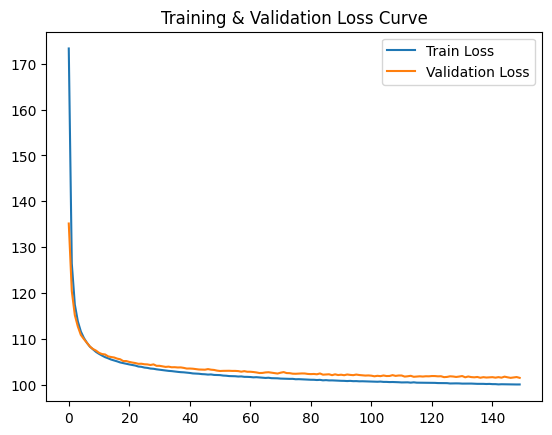

SSIM (Test set): 0.8689
PSNR (Test set): 19.8352
Generated 10 images in 0.0007 sec


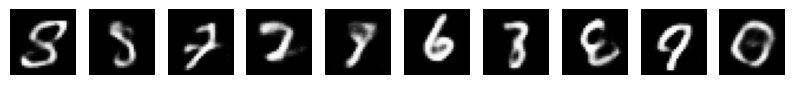

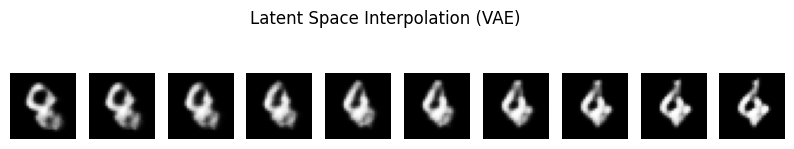

MS-SSIM (similarity): 0.4060 | Diversity (1 - MS-SSIM): 0.5940


In [7]:
total_time = time.time() - total_start
print(f"Total Training Time: {total_time:.2f} sec, Avg per epoch: {total_time/epoch:.2f} sec")

# 載入最佳模型
model.load_state_dict(torch.load(best_model_path))
model.eval()

# 1. Loss 曲線
plt.plot(train_losses, label="Train Loss")
plt.plot(valid_losses, label="Validation Loss")
plt.legend()
plt.title("Training & Validation Loss Curve")
plt.show()

# 2. 清晰度
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
import numpy as np

# 2. 清晰度 (SSIM + PSNR)
def evaluate_ssim_psnr(model, dataloader, device):
    model.eval()
    ssim_scores, psnr_scores = [], []
    with torch.no_grad():
        for data, _ in dataloader:
            data = data.to(device)
            recon, _, _ = model(data)

            real_imgs = data.view(-1, 28, 28).cpu().numpy()
            fake_imgs = recon.view(-1, 28, 28).cpu().numpy()

            for i in range(len(real_imgs)):
                ssim_scores.append(
                    ssim(real_imgs[i], fake_imgs[i], data_range=1.0)
                )
                psnr_scores.append(
                    psnr(real_imgs[i], fake_imgs[i], data_range=1.0)
                )

    return np.mean(ssim_scores), np.mean(psnr_scores)

ssim_score, psnr_score = evaluate_ssim_psnr(model, test_loader, device)
print(f"SSIM (Test set): {ssim_score:.4f}")
print(f"PSNR (Test set): {psnr_score:.4f}")

# 3. 隨機生成樣本 + 推理時間
start_gen = time.time()
with torch.no_grad():
    z = torch.randn(10, latent_dim).to(device)
    sample = model.decode(z).cpu()
end_gen = time.time()
print(f"Generated 10 images in {end_gen-start_gen:.4f} sec")

plt.figure(figsize=(10, 2))
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(sample[i].view(28, 28), cmap="gray")
    plt.axis("off")
plt.show()

# 4. 可控性
with torch.no_grad():
    z1 = torch.randn(1, latent_dim).to(device)
    z2 = torch.randn(1, latent_dim).to(device)
    interpolations = []
    for alpha in np.linspace(0, 1, 10):
        z = (1 - alpha) * z1 + alpha * z2
        interpolations.append(model.decode(z).cpu())
plt.figure(figsize=(10, 2))
for i, img in enumerate(interpolations):
    plt.subplot(1, 10, i+1)
    plt.imshow(img.view(28, 28), cmap="gray")
    plt.axis("off")
plt.suptitle("Latent Space Interpolation (VAE)")
plt.show()

# 5. 穩定性
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure

# 3-scale + 小 kernel，能在 28x28 上穩定運作
ms_ssim_metric = MultiScaleStructuralSimilarityIndexMeasure(
    data_range=1.0,
    betas=(0.0448, 0.2856, 0.3001),  # 3 scales
    kernel_size=(7, 7)               # 小 kernel，避免尺寸限制
).to(device)

with torch.no_grad():
    # 兩組獨立隨機生成樣本，用來衡量多樣性（越不相似 => 多樣性越高）
    z1 = torch.randn(64, latent_dim).to(device)
    z2 = torch.randn(64, latent_dim).to(device)
    img1 = model.decode(z1).view(-1, 1, 28, 28)  # [N,1,28,28]，值在 [0,1]
    img2 = model.decode(z2).view(-1, 1, 28, 28)

    ms_ssim_val = ms_ssim_metric(img1, img2).item()

# 直觀一點：回報「多樣性」= 1 - MS-SSIM（越高越多樣，越不易 collapse）
diversity = 1.0 - ms_ssim_val
print(f"MS-SSIM (similarity): {ms_ssim_val:.4f} | Diversity (1 - MS-SSIM): {diversity:.4f}")

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random
import time
from tqdm import tqdm

# 指標
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 參數
batch_size = 128
epochs = 100
lr = 2e-4
z_dim = 100
patience = 10

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [0,1] -> [-1,1]
])
full_train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# train/valid split
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

# DCGAN 模型定義
nz  = z_dim
ngf = 64
ndf = 64
nc  = 1        # 灰階

class DCGAN_G(nn.Module):
    def __init__(self, z_dim=nz, nc=nc, ngf=ngf):
        super().__init__()
        self.net = nn.Sequential(
            # z -> 256*7*7
            nn.Linear(z_dim, ngf*4*7*7),
            nn.BatchNorm1d(ngf*4*7*7),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf*4, 7, 7)),                # (B,256,7,7)

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),  # (B,128,14,14)
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),    # (B,64,28,28)
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, nc, 3, 1, 1, bias=False),                # (B,1,28,28)
            nn.Tanh()  # 輸出 [-1,1]
        )
    def forward(self, z):
        return self.net(z)

class DCGAN_D(nn.Module):
    def __init__(self, nc=nc, ndf=ndf):
        super().__init__()
        self.net = nn.Sequential(
            # (B,1,28,28) -> (B,64,14,14)
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,64,14,14) -> (B,128,7,7)
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            # (B,128,7,7) -> (B,1,1,1)
            nn.Conv2d(ndf*2, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.net(x).view(-1, 1)

# DCGAN 初始化
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('Linear') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gen  = DCGAN_G(nz).to(device)
disc = DCGAN_D().to(device)
gen.apply(weights_init); disc.apply(weights_init)

criterion = nn.BCELoss()
opt_g = optim.Adam(gen.parameters(),  lr=lr, betas=(0.5, 0.999))
opt_d = optim.Adam(disc.parameters(), lr=lr, betas=(0.5, 0.999))

gen_losses, disc_losses, val_losses = [], [], []
best_val = float("inf")
early = 0
best_gen_path = "gan_gen_best.pth"

# 訓練
total_start = time.time()
for epoch in range(1, epochs+1):
    ep_start = time.time()
    gen.train(); disc.train()
    g_loss_sum = 0.0
    d_loss_sum = 0.0

    for real, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        real = real.to(device)
        bsz  = real.size(0)
        ones  = torch.ones(bsz, 1, device=device)
        zeros = torch.zeros(bsz, 1, device=device)

        # Train D（一次）
        z = torch.randn(bsz, nz, device=device)
        fake = gen(z)
        d_real = disc(real)
        d_fake = disc(fake.detach())
        d_loss = 0.5 * (criterion(d_real, ones) + criterion(d_fake, zeros))
        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()

        # Train G（一次）
        d_fake_for_g = disc(fake)
        g_loss = criterion(d_fake_for_g, ones)
        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()

        g_loss_sum += g_loss.item()
        d_loss_sum += d_loss.item()

    avg_g = g_loss_sum / len(train_loader)
    avg_d = d_loss_sum / len(train_loader)
    gen_losses.append(avg_g)
    disc_losses.append(avg_d)

    # Validation（proxy：讓 D 誤判 fake 為真）
    gen.eval(); disc.eval()
    v_sum = 0.0
    with torch.no_grad():
        for real, _ in valid_loader:
            bsz = real.size(0)
            real = real.to(device)
            z = torch.randn(bsz, nz, device=device)
            fake = gen(z)
            v_out = disc(fake)
            v_loss = criterion(v_out, torch.ones_like(v_out))
            v_sum += v_loss.item()
    v_avg = v_sum / len(valid_loader)
    val_losses.append(v_avg)

    ep_time = time.time() - ep_start
    print(f"Epoch {epoch} | G_loss: {avg_g:.4f} | D_loss: {avg_d:.4f} | Val: {v_avg:.4f} | Time: {ep_time:.2f}s")

    # 早停 & 儲存最佳生成器（以 proxy Val 最小）
    if v_avg < best_val:
        best_val = v_avg
        torch.save(gen.state_dict(), best_gen_path)
        print("Saved best Generator")
        early = 0
    else:
        early += 1
        if early >= patience:
            print("Early stopping triggered")
            break

total_time = time.time() - total_start
print(f"Total Training Time: {total_time:.2f}s | Avg/Epoch: {total_time/epoch:.2f}s")

Epoch 1/100: 100%|██████████| 375/375 [00:19<00:00, 18.97it/s]


Epoch 1 | G_loss: 1.3085 | D_loss: 0.4608 | Val: 1.3770 | Time: 22.52s
Saved best Generator


Epoch 2/100: 100%|██████████| 375/375 [00:17<00:00, 21.30it/s]


Epoch 2 | G_loss: 1.4086 | D_loss: 0.4104 | Val: 1.6040 | Time: 21.80s


Epoch 3/100: 100%|██████████| 375/375 [00:20<00:00, 18.62it/s]


Epoch 3 | G_loss: 1.2390 | D_loss: 0.4968 | Val: 0.5955 | Time: 22.90s
Saved best Generator


Epoch 4/100: 100%|██████████| 375/375 [00:18<00:00, 20.10it/s]


Epoch 4 | G_loss: 1.2169 | D_loss: 0.5062 | Val: 0.3819 | Time: 21.60s
Saved best Generator


Epoch 5/100: 100%|██████████| 375/375 [00:19<00:00, 19.16it/s]


Epoch 5 | G_loss: 1.1985 | D_loss: 0.5155 | Val: 0.2478 | Time: 22.93s
Saved best Generator


Epoch 6/100: 100%|██████████| 375/375 [00:23<00:00, 16.19it/s]


Epoch 6 | G_loss: 1.1786 | D_loss: 0.5348 | Val: 0.9807 | Time: 26.39s


Epoch 7/100: 100%|██████████| 375/375 [00:18<00:00, 20.22it/s]


Epoch 7 | G_loss: 1.1324 | D_loss: 0.5441 | Val: 1.5032 | Time: 21.95s


Epoch 8/100: 100%|██████████| 375/375 [00:17<00:00, 21.69it/s]


Epoch 8 | G_loss: 1.1234 | D_loss: 0.5574 | Val: 1.1075 | Time: 19.98s


Epoch 9/100: 100%|██████████| 375/375 [00:17<00:00, 21.10it/s]


Epoch 9 | G_loss: 1.0970 | D_loss: 0.5680 | Val: 0.7533 | Time: 20.51s


Epoch 10/100: 100%|██████████| 375/375 [00:17<00:00, 21.77it/s]


Epoch 10 | G_loss: 1.0786 | D_loss: 0.5772 | Val: 0.6331 | Time: 20.44s


Epoch 11/100: 100%|██████████| 375/375 [00:17<00:00, 21.74it/s]


Epoch 11 | G_loss: 1.0289 | D_loss: 0.5978 | Val: 0.9118 | Time: 20.07s


Epoch 12/100: 100%|██████████| 375/375 [00:17<00:00, 21.28it/s]


Epoch 12 | G_loss: 1.0298 | D_loss: 0.6012 | Val: 0.2445 | Time: 20.31s
Saved best Generator


Epoch 13/100: 100%|██████████| 375/375 [00:17<00:00, 21.79it/s]


Epoch 13 | G_loss: 1.0311 | D_loss: 0.5974 | Val: 0.3183 | Time: 20.23s


Epoch 14/100: 100%|██████████| 375/375 [00:16<00:00, 22.12it/s]


Epoch 14 | G_loss: 1.0354 | D_loss: 0.6004 | Val: 1.7472 | Time: 19.69s


Epoch 15/100: 100%|██████████| 375/375 [00:17<00:00, 21.33it/s]


Epoch 15 | G_loss: 1.0212 | D_loss: 0.6046 | Val: 1.9213 | Time: 20.30s


Epoch 16/100: 100%|██████████| 375/375 [00:17<00:00, 21.53it/s]


Epoch 16 | G_loss: 1.0187 | D_loss: 0.6131 | Val: 1.5258 | Time: 20.34s


Epoch 17/100: 100%|██████████| 375/375 [00:17<00:00, 21.84it/s]


Epoch 17 | G_loss: 0.9967 | D_loss: 0.6096 | Val: 2.3141 | Time: 19.96s


Epoch 18/100: 100%|██████████| 375/375 [00:17<00:00, 21.38it/s]


Epoch 18 | G_loss: 0.9937 | D_loss: 0.6144 | Val: 0.8583 | Time: 20.20s


Epoch 19/100: 100%|██████████| 375/375 [00:17<00:00, 21.74it/s]


Epoch 19 | G_loss: 0.9924 | D_loss: 0.6189 | Val: 0.1643 | Time: 20.13s
Saved best Generator


Epoch 20/100: 100%|██████████| 375/375 [00:16<00:00, 22.19it/s]


Epoch 20 | G_loss: 0.9974 | D_loss: 0.6160 | Val: 0.7986 | Time: 19.61s


Epoch 21/100: 100%|██████████| 375/375 [00:17<00:00, 21.60it/s]


Epoch 21 | G_loss: 0.9974 | D_loss: 0.6155 | Val: 0.7109 | Time: 20.07s


Epoch 22/100: 100%|██████████| 375/375 [00:17<00:00, 21.74it/s]


Epoch 22 | G_loss: 0.9832 | D_loss: 0.6212 | Val: 1.4037 | Time: 20.26s


Epoch 23/100: 100%|██████████| 375/375 [00:16<00:00, 22.16it/s]


Epoch 23 | G_loss: 0.9811 | D_loss: 0.6206 | Val: 0.5754 | Time: 19.62s


Epoch 24/100: 100%|██████████| 375/375 [00:17<00:00, 21.65it/s]


Epoch 24 | G_loss: 0.9770 | D_loss: 0.6234 | Val: 1.8979 | Time: 19.99s


Epoch 25/100: 100%|██████████| 375/375 [00:17<00:00, 21.83it/s]


Epoch 25 | G_loss: 0.9801 | D_loss: 0.6230 | Val: 2.9585 | Time: 20.16s


Epoch 26/100: 100%|██████████| 375/375 [00:16<00:00, 22.16it/s]


Epoch 26 | G_loss: 0.9757 | D_loss: 0.6238 | Val: 0.2570 | Time: 19.59s


Epoch 27/100: 100%|██████████| 375/375 [00:17<00:00, 21.21it/s]


Epoch 27 | G_loss: 0.9699 | D_loss: 0.6241 | Val: 0.0282 | Time: 20.43s
Saved best Generator


Epoch 28/100: 100%|██████████| 375/375 [00:17<00:00, 21.66it/s]


Epoch 28 | G_loss: 0.9663 | D_loss: 0.6295 | Val: 0.1906 | Time: 20.33s


Epoch 29/100: 100%|██████████| 375/375 [00:17<00:00, 22.05it/s]


Epoch 29 | G_loss: 0.9646 | D_loss: 0.6282 | Val: 1.2794 | Time: 19.69s


Epoch 30/100: 100%|██████████| 375/375 [00:17<00:00, 21.31it/s]


Epoch 30 | G_loss: 0.9625 | D_loss: 0.6281 | Val: 0.7467 | Time: 20.34s


Epoch 31/100: 100%|██████████| 375/375 [00:17<00:00, 21.75it/s]


Epoch 31 | G_loss: 0.9610 | D_loss: 0.6303 | Val: 1.3529 | Time: 20.21s


Epoch 32/100: 100%|██████████| 375/375 [00:16<00:00, 22.14it/s]


Epoch 32 | G_loss: 0.9558 | D_loss: 0.6327 | Val: 1.7180 | Time: 19.55s


Epoch 33/100: 100%|██████████| 375/375 [00:17<00:00, 21.51it/s]


Epoch 33 | G_loss: 0.9427 | D_loss: 0.6369 | Val: 2.0526 | Time: 20.18s


Epoch 34/100: 100%|██████████| 375/375 [00:17<00:00, 21.76it/s]


Epoch 34 | G_loss: 0.9487 | D_loss: 0.6321 | Val: 1.4183 | Time: 20.29s


Epoch 35/100: 100%|██████████| 375/375 [00:16<00:00, 22.10it/s]


Epoch 35 | G_loss: 0.9449 | D_loss: 0.6357 | Val: 0.5551 | Time: 19.62s


Epoch 36/100: 100%|██████████| 375/375 [00:17<00:00, 21.37it/s]


Epoch 36 | G_loss: 0.9495 | D_loss: 0.6335 | Val: 0.3709 | Time: 20.22s


Epoch 37/100: 100%|██████████| 375/375 [00:17<00:00, 21.52it/s]


Epoch 37 | G_loss: 0.9402 | D_loss: 0.6370 | Val: 3.4158 | Time: 20.45s
Early stopping triggered
Total Training Time: 762.95s | Avg/Epoch: 20.62s


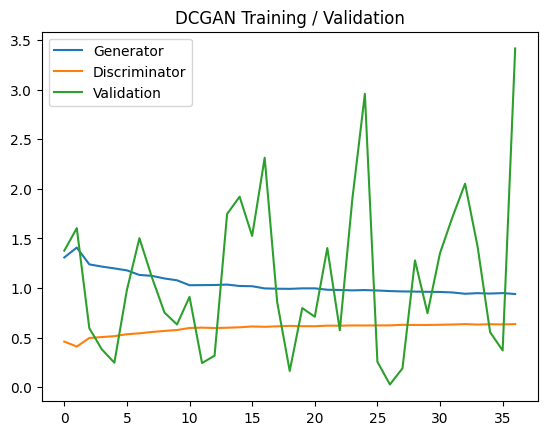

SSIM (DCGAN, NN-ref): 0.6804
PSNR (DCGAN, NN-ref): 14.42 dB
Generated 10 images in 0.0039 sec


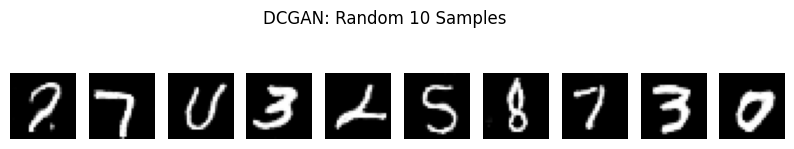

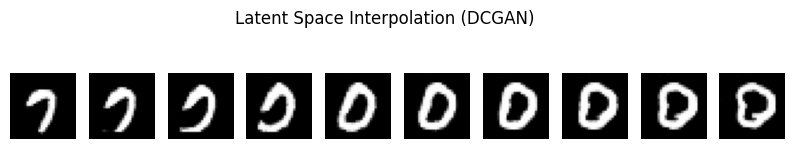

MS-SSIM (similarity): 0.3194 | Diversity (1 - MS-SSIM): 0.6806


In [11]:
# 載入最佳生成器
gen.load_state_dict(torch.load(best_gen_path, map_location=device))
gen.eval()

# Loss 曲線
plt.figure()
plt.plot(gen_losses, label="Generator")
plt.plot(disc_losses, label="Discriminator")
plt.plot(val_losses, label="Validation")
plt.legend(); plt.title("DCGAN Training / Validation"); plt.show()

# 清晰度
def collect_test_images_01(dataloader, limit=None):
    xs = []
    for x, _ in dataloader:
        xs.append((x + 1)/2)  # 反正規化 [0,1]
        if limit is not None and sum(t.size(0) for t in xs) >= limit:
            break
    x = torch.cat(xs, dim=0)
    if limit is not None:
        x = x[:limit]
    return x  # [N,1,28,28]

with torch.no_grad():
    # 生成樣本
    N_fake = 500
    z = torch.randn(N_fake, nz, device=device)
    fake = gen(z)          # [-1,1]
    fake_01 = (fake + 1) / 2  # [0,1]

    real_all_01 = collect_test_images_01(test_loader).to(device)  # [N,1,28,28]

    # 最近鄰（MSE）對齊
    fake_flat = fake_01.view(N_fake, -1)
    real_flat = real_all_01.view(real_all_01.size(0), -1)

    def chunk_min_mse_indices(A, B, chunk=200):
        mins = []
        for i in range(0, A.size(0), chunk):
            Ai = A[i:i+chunk]     # [c,D]
            Ai2 = (Ai**2).sum(dim=1, keepdim=True)
            B2  = (B**2).sum(dim=1, keepdim=True).T
            AB  = Ai @ B.T
            dist2 = Ai2 + B2 - 2*AB
            idx = dist2.argmin(dim=1)
            mins.append(idx)
        return torch.cat(mins, dim=0)

    nn_idx = chunk_min_mse_indices(fake_flat, real_flat, chunk=200)  # [N_fake]

    # 計算 SSIM/PSNR
    ssim_list, psnr_list = [], []
    fake_np = fake_01.detach().cpu().numpy()
    real_np = real_all_01[nn_idx].detach().cpu().numpy()
    for i in range(N_fake):
        f = fake_np[i,0]; r = real_np[i,0]
        ssim_list.append(ssim(r, f, data_range=1.0))
        psnr_list.append(psnr(r, f, data_range=1.0))
    print(f"SSIM (DCGAN, NN-ref): {np.mean(ssim_list):.4f}")
    print(f"PSNR (DCGAN, NN-ref): {np.mean(psnr_list):.2f} dB")

# 隨機生成 10 張 + 推理時間
start_gen = time.time()
with torch.no_grad():
    z = torch.randn(10, nz, device=device)
    samples = gen(z)
end_gen = time.time()
print(f"Generated 10 images in {end_gen - start_gen:.4f} sec")

samples_show = (samples + 1)/2
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(samples_show[i,0].cpu(), cmap="gray")
    plt.axis("off")
plt.suptitle("DCGAN: Random 10 Samples")
plt.show()

# 可控性
with torch.no_grad():
    z1 = torch.randn(1, nz, device=device)
    z2 = torch.randn(1, nz, device=device)
    inter_imgs = []
    for a in np.linspace(0,1,10):
        zt = (1-a)*z1 + a*z2
        inter_imgs.append(gen(zt))
    inter = torch.cat(inter_imgs, dim=0)
    inter = (inter + 1)/2
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(inter[i,0].cpu(), cmap="gray")
    plt.axis("off")
plt.suptitle("Latent Space Interpolation (DCGAN)")
plt.show()

# 穩定性
ms_ssim_metric = MultiScaleStructuralSimilarityIndexMeasure(
    data_range=1.0,
    betas=(0.0448, 0.2856, 0.3001),
    kernel_size=(7,7)
).to(device)

with torch.no_grad():
    zA = torch.randn(64, nz, device=device)
    zB = torch.randn(64, nz, device=device)
    imgA = (gen(zA) + 1) / 2
    imgB = (gen(zB) + 1) / 2
    ms_val = ms_ssim_metric(imgA, imgB).item()

diversity = 1.0 - ms_val
print(f"MS-SSIM (similarity): {ms_val:.4f} | Diversity (1 - MS-SSIM): {diversity:.4f}")

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random, time
from tqdm import tqdm

# 指標
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure

# 固定隨機種子
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# 超參數
batch_size = 128
epochs = 100
lr = 1e-3
z_dim = 100
num_classes = 10
patience = 10

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [0,1] → [-1,1]
])
full_train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset    = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# train/valid split
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last=False)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

def one_hot(y, n_cls=10):
    return F.one_hot(y, n_cls).float()

def label_map(y, H=28, W=28, n_cls=10):
    oh = one_hot(y, n_cls)
    return oh.view(-1, n_cls, 1, 1).expand(-1, n_cls, H, W)

nz, ngf, ndf, nc = z_dim, 64, 64, 1

#G : {x, z} → y
class CondGenerator(nn.Module):
    def __init__(self, z_dim=nz, n_cls=num_classes, nc=1, ngf=64):
        super().__init__()
        in_dim = z_dim + n_cls
        self.net = nn.Sequential(
            nn.Linear(in_dim, ngf*4*7*7),
            nn.BatchNorm1d(ngf*4*7*7),
            nn.ReLU(True),
            nn.Unflatten(1, (ngf*4, 7, 7)),

            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),

            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),

            nn.Conv2d(ngf, nc, 3, 1, 1, bias=False),
            nn.Tanh()
        )
    def forward(self, z, y):
        y_oh = one_hot(y, num_classes)
        zc = torch.cat([z, y_oh], dim=1)
        return self.net(zc)

class CondDiscriminator(nn.Module):
    def __init__(self, n_cls=num_classes, nc=1, ndf=64):
        super().__init__()
        in_ch = nc + n_cls
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(ndf*2, 1, 7, 1, 0, bias=False),
            nn.Sigmoid()
        )
    def forward(self, x, y):
        y_map = label_map(y, H=28, W=28, n_cls=num_classes)  # [B,10,28,28]
        x_in = torch.cat([x, y_map.to(x.dtype)], dim=1)      # [B,11,28,28]
        return self.net(x_in).view(-1, 1)

# 初始化
def weights_init(m):
    name = m.__class__.__name__
    if 'Conv' in name or 'Linear' in name:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    if 'BatchNorm' in name:
        nn.init.normal_(m.weight.data, 1.0, 0.02); nn.init.constant_(m.bias.data, 0)

G = CondGenerator(nz, num_classes, nc, ngf).to(device).apply(weights_init)
D = CondDiscriminator(num_classes, nc, ndf).to(device).apply(weights_init)

criterion = nn.BCELoss()
opt_g = optim.Adam(G.parameters(), lr=lr, betas=(0.5, 0.999))
opt_d = optim.Adam(D.parameters(), lr=lr, betas=(0.5, 0.999))

gen_losses, disc_losses, val_losses = [], [], []
best_val = float('inf'); early = 0
best_gen_path = "cgan_gen_best.pth"

# 訓練
total_start = time.time()
for epoch in range(1, epochs+1):
    ep_start = time.time()
    G.train(); D.train()
    g_sum = d_sum = 0.0

    for real, y in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        real, y = real.to(device), y.to(device)
        bsz = real.size(0)
        ones  = torch.ones(bsz, 1, device=device)
        zeros = torch.zeros(bsz, 1, device=device)

        # Train D
        z = torch.randn(bsz, nz, device=device)
        fake = G(z, y).detach()
        d_real = D(real, y)
        d_fake = D(fake, y)
        d_loss = 0.5 * (criterion(d_real, ones*0.9) + criterion(d_fake, zeros))  # label smoothing on real
        opt_d.zero_grad()
        d_loss.backward()
        opt_d.step()

        # Train G
        z = torch.randn(bsz, nz, device=device)
        fake = G(z, y)
        d_fake_for_g = D(fake, y)
        g_loss = criterion(d_fake_for_g, ones)
        opt_g.zero_grad()
        g_loss.backward()
        opt_g.step()

        g_sum += g_loss.item(); d_sum += d_loss.item()

    avg_g, avg_d = g_sum/len(train_loader), d_sum/len(train_loader)
    gen_losses.append(avg_g); disc_losses.append(avg_d)

    # 驗證
    G.eval()
    D.eval()
    v_sum = 0.0
    with torch.no_grad():
        for real, y in valid_loader:
            real, y = real.to(device), y.to(device)
            z = torch.randn(real.size(0), nz, device=device)
            fake = G(z, y)
            v_out = D(fake, y)
            v_loss = criterion(v_out, torch.ones_like(v_out))
            v_sum += v_loss.item()
    v_avg = v_sum / len(valid_loader); val_losses.append(v_avg)

    ep_time = time.time() - ep_start
    print(f"Epoch {epoch} | G: {avg_g:.4f} | D: {avg_d:.4f} | Val: {v_avg:.4f} | Time: {ep_time:.2f}s")

    if v_avg < best_val:
        best_val = v_avg; torch.save(G.state_dict(), best_gen_path)
        print("Saved best Generator"); early = 0
    else:
        early += 1
        if early >= patience:
            print("Early stopping triggered"); break

Epoch 1/100: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


Epoch 1 | G: 1.1727 | D: 0.6599 | Val: 0.9631 | Time: 25.11s
Saved best Generator


Epoch 2/100: 100%|██████████| 375/375 [00:22<00:00, 16.70it/s]


Epoch 2 | G: 1.0503 | D: 0.6609 | Val: 0.8752 | Time: 25.51s
Saved best Generator


Epoch 3/100: 100%|██████████| 375/375 [00:21<00:00, 17.07it/s]


Epoch 3 | G: 0.9296 | D: 0.6834 | Val: 0.8603 | Time: 25.07s
Saved best Generator


Epoch 4/100: 100%|██████████| 375/375 [00:21<00:00, 17.19it/s]


Epoch 4 | G: 0.8966 | D: 0.6874 | Val: 0.7928 | Time: 24.95s
Saved best Generator


Epoch 5/100: 100%|██████████| 375/375 [00:21<00:00, 17.34it/s]


Epoch 5 | G: 0.8782 | D: 0.6892 | Val: 0.7774 | Time: 24.67s
Saved best Generator


Epoch 6/100: 100%|██████████| 375/375 [00:21<00:00, 17.26it/s]


Epoch 6 | G: 0.8614 | D: 0.6916 | Val: 0.8204 | Time: 24.83s


Epoch 7/100: 100%|██████████| 375/375 [00:21<00:00, 17.27it/s]


Epoch 7 | G: 0.8527 | D: 0.6919 | Val: 0.8831 | Time: 24.78s


Epoch 8/100: 100%|██████████| 375/375 [00:21<00:00, 17.31it/s]


Epoch 8 | G: 0.8436 | D: 0.6919 | Val: 0.8255 | Time: 24.65s


Epoch 9/100: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


Epoch 9 | G: 0.8348 | D: 0.6911 | Val: 0.7825 | Time: 24.49s


Epoch 10/100: 100%|██████████| 375/375 [00:21<00:00, 17.42it/s]


Epoch 10 | G: 0.8323 | D: 0.6917 | Val: 0.7687 | Time: 24.98s
Saved best Generator


Epoch 11/100: 100%|██████████| 375/375 [00:21<00:00, 17.09it/s]


Epoch 11 | G: 0.8269 | D: 0.6910 | Val: 0.8440 | Time: 24.91s


Epoch 12/100: 100%|██████████| 375/375 [00:21<00:00, 17.49it/s]


Epoch 12 | G: 0.8204 | D: 0.6903 | Val: 0.7675 | Time: 24.46s
Saved best Generator


Epoch 13/100: 100%|██████████| 375/375 [00:21<00:00, 17.31it/s]


Epoch 13 | G: 0.8161 | D: 0.6902 | Val: 0.8674 | Time: 24.74s


Epoch 14/100: 100%|██████████| 375/375 [00:21<00:00, 17.43it/s]


Epoch 14 | G: 0.8130 | D: 0.6899 | Val: 0.7743 | Time: 24.49s


Epoch 15/100: 100%|██████████| 375/375 [00:21<00:00, 17.08it/s]


Epoch 15 | G: 0.8096 | D: 0.6898 | Val: 0.7852 | Time: 25.13s


Epoch 16/100: 100%|██████████| 375/375 [00:21<00:00, 17.28it/s]


Epoch 16 | G: 0.8091 | D: 0.6895 | Val: 0.7661 | Time: 24.59s
Saved best Generator


Epoch 17/100: 100%|██████████| 375/375 [00:21<00:00, 17.77it/s]


Epoch 17 | G: 0.8068 | D: 0.6894 | Val: 0.7725 | Time: 24.08s


Epoch 18/100: 100%|██████████| 375/375 [00:21<00:00, 17.71it/s]


Epoch 18 | G: 0.8056 | D: 0.6898 | Val: 0.7858 | Time: 24.13s


Epoch 19/100: 100%|██████████| 375/375 [00:21<00:00, 17.61it/s]


Epoch 19 | G: 0.8036 | D: 0.6892 | Val: 0.7769 | Time: 24.21s


Epoch 20/100: 100%|██████████| 375/375 [00:21<00:00, 17.73it/s]


Epoch 20 | G: 0.8025 | D: 0.6895 | Val: 0.7891 | Time: 24.09s


Epoch 21/100: 100%|██████████| 375/375 [00:21<00:00, 17.76it/s]


Epoch 21 | G: 0.8016 | D: 0.6890 | Val: 0.8211 | Time: 24.41s


Epoch 22/100: 100%|██████████| 375/375 [00:21<00:00, 17.70it/s]


Epoch 22 | G: 0.8028 | D: 0.6894 | Val: 0.7940 | Time: 24.07s


Epoch 23/100: 100%|██████████| 375/375 [00:21<00:00, 17.60it/s]


Epoch 23 | G: 0.8010 | D: 0.6891 | Val: 0.7959 | Time: 24.18s


Epoch 24/100: 100%|██████████| 375/375 [00:21<00:00, 17.59it/s]


Epoch 24 | G: 0.8003 | D: 0.6890 | Val: 0.8066 | Time: 24.31s


Epoch 25/100: 100%|██████████| 375/375 [00:21<00:00, 17.53it/s]


Epoch 25 | G: 0.8002 | D: 0.6889 | Val: 0.7921 | Time: 24.34s


Epoch 26/100: 100%|██████████| 375/375 [00:21<00:00, 17.74it/s]


Epoch 26 | G: 0.8002 | D: 0.6891 | Val: 0.8005 | Time: 24.08s
Early stopping triggered


Generated 100 conditional images in 0.0167 sec


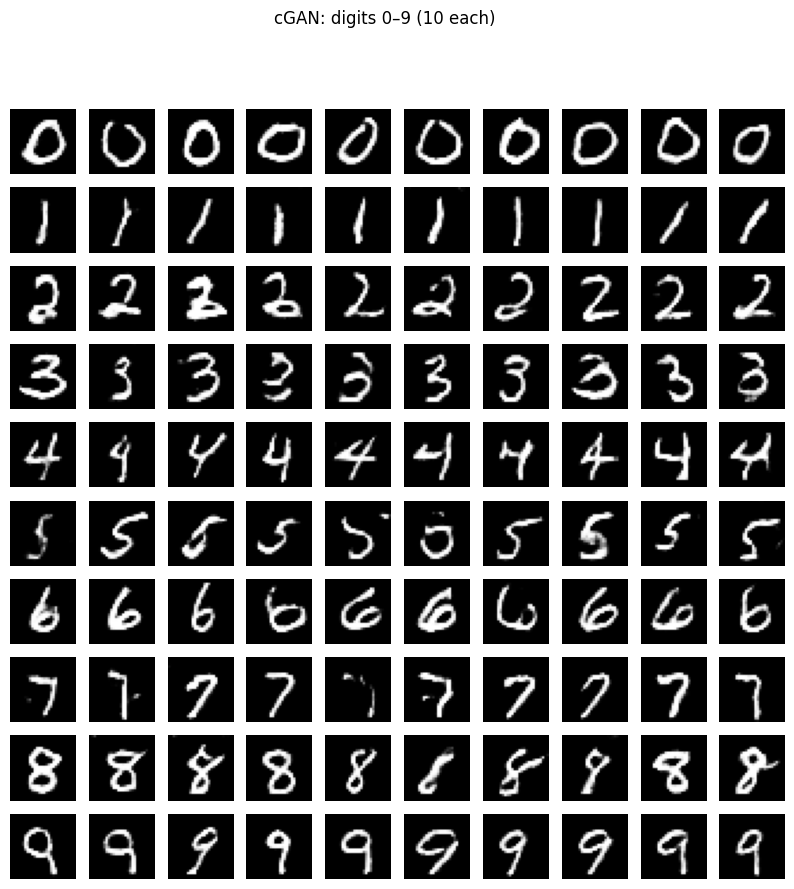

Total Training Time: 646.45s | Avg/Epoch: 24.86s


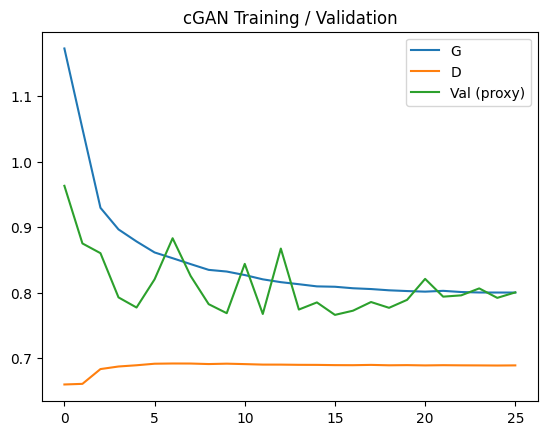

SSIM (cGAN, NN-ref): 0.6917
PSNR (cGAN, NN-ref): 15.04 dB


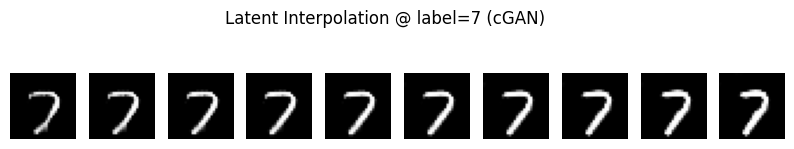

MS-SSIM (similarity): 0.2714 | Diversity (1 - MS-SSIM): 0.7286


In [18]:
# 載入最佳
G.load_state_dict(torch.load(best_gen_path, map_location=device))
G.eval()

# 生成 0–9 各 10 張（10×10 圖格）
start_gen = time.time()
with torch.no_grad():
    tiles = []
    for d in range(num_classes):
        z = torch.randn(10, nz, device=device)
        y = torch.full((10,), d, dtype=torch.long, device=device)
        g = G(z, y)           # [-1,1]
        g01 = (g + 1)/2       # [0,1]
        tiles.append(g01.cpu())
grid = torch.cat(tiles, dim=0)  # [100,1,28,28]
end_gen = time.time()
print(f"Generated 100 conditional images in {end_gen - start_gen:.4f} sec")

plt.figure(figsize=(10,10))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.imshow(grid[i,0], cmap="gray"); plt.axis("off")
plt.suptitle("cGAN: digits 0–9 (10 each)"); plt.show()

total_time = time.time() - total_start
print(f"Total Training Time: {total_time:.2f}s | Avg/Epoch: {total_time/epoch:.2f}s")

# Loss 曲線
plt.figure()
plt.plot(gen_losses, label="G"); plt.plot(disc_losses, label="D"); plt.plot(val_losses, label="Val (proxy)")
plt.legend(); plt.title("cGAN Training / Validation"); plt.show()

# 清晰度：SSIM + PSNR
def collect_test_images_01(dataloader, limit=None):
    xs = []
    for x, _ in dataloader:
        xs.append((x + 1)/2)
        if limit is not None and sum(t.size(0) for t in xs) >= limit:
            break
    x = torch.cat(xs, dim=0)
    if limit is not None: x = x[:limit]
    return x  # [N,1,28,28]

with torch.no_grad():
    N_fake = 500
    # 隨機標籤生成（均勻抽 0-9）
    y_fake = torch.randint(0, num_classes, (N_fake,), device=device)
    z = torch.randn(N_fake, nz, device=device)
    fake = G(z, y_fake)               # [-1,1]
    fake_01 = (fake + 1)/2            # [0,1]

    real_all_01 = collect_test_images_01(test_loader).to(device)

    fake_flat = fake_01.view(N_fake, -1)
    real_flat = real_all_01.view(real_all_01.size(0), -1)

    def chunk_min_mse_indices(A, B, chunk=200):
        mins = []
        for i in range(0, A.size(0), chunk):
            Ai = A[i:i+chunk]
            Ai2 = (Ai**2).sum(dim=1, keepdim=True)
            B2  = (B**2).sum(dim=1, keepdim=True).T
            AB  = Ai @ B.T
            dist2 = Ai2 + B2 - 2*AB
            idx = dist2.argmin(dim=1)
            mins.append(idx)
        return torch.cat(mins, dim=0)

    nn_idx = chunk_min_mse_indices(fake_flat, real_flat, chunk=200)

    ssim_list, psnr_list = [], []
    fake_np = fake_01.detach().cpu().numpy()
    real_np = real_all_01[nn_idx].detach().cpu().numpy()
    for i in range(N_fake):
        f = fake_np[i,0]; r = real_np[i,0]
        ssim_list.append(ssim(r, f, data_range=1.0))
        psnr_list.append(psnr(r, f, data_range=1.0))
    print(f"SSIM (cGAN, NN-ref): {np.mean(ssim_list):.4f}")
    print(f"PSNR (cGAN, NN-ref): {np.mean(psnr_list):.2f} dB")

# 可控性：Latent Space Interpolation
with torch.no_grad():
    digit = 7
    y = torch.full((1,), digit, dtype=torch.long, device=device)
    z1 = torch.randn(1, nz, device=device)
    z2 = torch.randn(1, nz, device=device)
    inter = []
    for a in np.linspace(0,1,10):
        zt = (1-a)*z1 + a*z2
        inter.append(((G(zt, y)+1)/2).cpu())
    inter = torch.cat(inter, dim=0)
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1)
    plt.imshow(inter[i,0], cmap="gray"); plt.axis("off")
plt.suptitle("Latent Interpolation @ label=7 (cGAN)"); plt.show()

# 穩定性：MS-SSIM
ms_ssim_metric = MultiScaleStructuralSimilarityIndexMeasure(
    data_range=1.0, betas=(0.0448, 0.2856, 0.3001), kernel_size=(7,7)
).to(device)
with torch.no_grad():
    yA = torch.randint(0, num_classes, (64,), device=device)
    yB = torch.randint(0, num_classes, (64,), device=device)
    zA = torch.randn(64, nz, device=device)
    zB = torch.randn(64, nz, device=device)
    imgA = (G(zA, yA) + 1)/2
    imgB = (G(zB, yB) + 1)/2
    ms_val = ms_ssim_metric(imgA, imgB).item()
diversity = 1.0 - ms_val
print(f"MS-SSIM (similarity): {ms_val:.4f} | Diversity (1 - MS-SSIM): {diversity:.4f}")

In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import random, time
from tqdm import tqdm

# 指標
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio as psnr
from torchmetrics.image import MultiScaleStructuralSimilarityIndexMeasure

# 固定隨機種子
seed = 42
torch.manual_seed(seed); np.random.seed(seed); random.seed(seed)

# 參數
batch_size = 128
epochs = 50
patience = 10
lr = 2e-4
img_size = 28
nc = 1
T = 300
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # [-1,1]
])
full_train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset       = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# train/valid split
train_size = int(0.8 * len(full_train_dataset))
valid_size = len(full_train_dataset) - train_size
train_dataset, valid_dataset = random_split(full_train_dataset, [train_size, valid_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, drop_last=False)

def linear_beta_schedule(timesteps, beta_start=1e-4, beta_end=0.02):
    return torch.linspace(beta_start, beta_end, timesteps)

betas = linear_beta_schedule(T).to(device)
alphas = 1.0 - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1,0), value=1.0)

sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.0 - alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

posterior_variance = betas * (1.0 - alphas_cumprod_prev) / (1.0 - alphas_cumprod)

def extract(a, t, x_shape):
    # [B,1,1,1]
    b = t.shape[0]
    out = a.gather(-1, t).reshape(b, *((1,) * (len(x_shape)-1)))
    return out

def q_sample(x0, t, noise=None):
    # x_t = sqrt(bar_alpha_t) * x0 + sqrt(1-bar_alpha_t) * noise
    if noise is None:
        noise = torch.randn_like(x0)
    return extract(sqrt_alphas_cumprod, t, x0.shape) * x0 + extract(sqrt_one_minus_alphas_cumprod, t, x0.shape) * noise

# 小型 U-Net
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        device = t.device
        half = self.dim // 2
        freqs = torch.exp(
            torch.linspace(np.log(1.0), np.log(10000.0), steps=half, device=device)
        )
        args = t[:, None].float() * freqs[None, :]
        emb = torch.cat([torch.sin(args), torch.cos(args)], dim=-1)
        return emb

class ResBlock(nn.Module):
    def __init__(self, in_ch, out_ch, t_emb_dim):
        super().__init__()
        self.mlp = nn.Sequential(nn.SiLU(), nn.Linear(t_emb_dim, out_ch))
        self.block1 = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(out_ch, out_ch, 3, 1, 1), nn.GroupNorm(8, out_ch), nn.SiLU()
        )
        self.res_conv = nn.Conv2d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()
    def forward(self, x, t_emb):
        h = self.block1(x)
        h = h + self.mlp(t_emb)[:, :, None, None]
        h = self.block2(h)
        return h + self.res_conv(x)

class TinyUNet(nn.Module):
    def __init__(self, in_ch=1, base_ch=64, t_emb_dim=128):
        super().__init__()
        self.time_mlp = nn.Sequential(
            SinusoidalPosEmb(t_emb_dim), nn.Linear(t_emb_dim, t_emb_dim*4), nn.SiLU(),
            nn.Linear(t_emb_dim*4, t_emb_dim)
        )
        # down
        self.conv_in = nn.Conv2d(in_ch, base_ch, 3, 1, 1)
        self.rb1 = ResBlock(base_ch, base_ch, t_emb_dim)
        self.down1 = nn.Conv2d(base_ch, base_ch*2, 4, 2, 1)  # 28->14
        self.rb2 = ResBlock(base_ch*2, base_ch*2, t_emb_dim)
        self.down2 = nn.Conv2d(base_ch*2, base_ch*4, 4, 2, 1)  # 14->7
        self.rb3 = ResBlock(base_ch*4, base_ch*4, t_emb_dim)
        # bottleneck
        self.rb_mid = ResBlock(base_ch*4, base_ch*4, t_emb_dim)
        # up
        self.up1 = nn.ConvTranspose2d(base_ch*4, base_ch*2, 4, 2, 1)  # 7->14
        self.rb4 = ResBlock(base_ch*4, base_ch*2, t_emb_dim)
        self.up2 = nn.ConvTranspose2d(base_ch*2, base_ch, 4, 2, 1)    # 14->28
        self.rb5 = ResBlock(base_ch*2, base_ch, t_emb_dim)
        self.conv_out = nn.Conv2d(base_ch, in_ch, 3, 1, 1)
    def forward(self, x, t):
        t_emb = self.time_mlp(t)
        h1 = self.conv_in(x); h1 = self.rb1(h1, t_emb)
        h2 = self.down1(h1);  h2 = self.rb2(h2, t_emb)
        h3 = self.down2(h2);  h3 = self.rb3(h3, t_emb)
        h  = self.rb_mid(h3, t_emb)
        h  = self.up1(h);     h  = torch.cat([h, h2], dim=1); h = self.rb4(h, t_emb)
        h  = self.up2(h);     h  = torch.cat([h, h1], dim=1); h = self.rb5(h, t_emb)
        out = self.conv_out(h)
        return out  # 預測噪音

model = TinyUNet(in_ch=1, base_ch=64, t_emb_dim=128).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)

# 訓練 / 驗證
def diffusion_loss_batch(x0):
    b = x0.size(0)
    t = torch.randint(0, T, (b,), device=device).long()
    noise = torch.randn_like(x0)
    xt = q_sample(x0, t, noise)
    pred_noise = model(xt, t)
    loss = F.mse_loss(pred_noise, noise)
    return loss

best_val = float('inf'); early = 0
best_model_path = "diffusion_best.pth"
train_losses, valid_losses = [], []

total_start = time.time()
for epoch in range(1, epochs+1):
    ep_start = time.time()
    model.train()
    train_loss_sum = 0.0
    for x, _ in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}"):
        x = x.to(device)  # [-1,1]
        loss = diffusion_loss_batch(x)
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        train_loss_sum += loss.item()
    avg_train = train_loss_sum / len(train_loader); train_losses.append(avg_train)

    # validation
    model.eval(); val_sum = 0.0
    with torch.no_grad():
        for x, _ in valid_loader:
            x = x.to(device)
            val_sum += diffusion_loss_batch(x).item()
    avg_val = val_sum / len(valid_loader); valid_losses.append(avg_val)

    ep_time = time.time() - ep_start
    print(f"Epoch {epoch} | Train: {avg_train:.4f} | Val: {avg_val:.4f} | Time: {ep_time:.2f}s")

    if avg_val < best_val:
        best_val = avg_val; torch.save(model.state_dict(), best_model_path)
        print("Saved best model"); early = 0
    else:
        early += 1
        if early >= patience:
            print("Early stopping triggered"); break

Epoch 1/50: 100%|██████████| 375/375 [00:52<00:00,  7.11it/s]


Epoch 1 | Train: 0.1189 | Val: 0.0650 | Time: 58.43s
Saved best model


Epoch 2/50: 100%|██████████| 375/375 [00:49<00:00,  7.54it/s]


Epoch 2 | Train: 0.0609 | Val: 0.0552 | Time: 54.94s
Saved best model


Epoch 3/50: 100%|██████████| 375/375 [00:49<00:00,  7.65it/s]


Epoch 3 | Train: 0.0531 | Val: 0.0520 | Time: 54.68s
Saved best model


Epoch 4/50: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


Epoch 4 | Train: 0.0498 | Val: 0.0488 | Time: 53.23s
Saved best model


Epoch 5/50: 100%|██████████| 375/375 [00:47<00:00,  7.84it/s]


Epoch 5 | Train: 0.0477 | Val: 0.0469 | Time: 53.41s
Saved best model


Epoch 6/50: 100%|██████████| 375/375 [00:47<00:00,  7.83it/s]


Epoch 6 | Train: 0.0469 | Val: 0.0463 | Time: 53.26s
Saved best model


Epoch 7/50: 100%|██████████| 375/375 [00:47<00:00,  7.83it/s]


Epoch 7 | Train: 0.0454 | Val: 0.0441 | Time: 53.22s
Saved best model


Epoch 8/50: 100%|██████████| 375/375 [00:47<00:00,  7.84it/s]


Epoch 8 | Train: 0.0445 | Val: 0.0436 | Time: 53.37s
Saved best model


Epoch 9/50: 100%|██████████| 375/375 [00:47<00:00,  7.91it/s]


Epoch 9 | Train: 0.0442 | Val: 0.0434 | Time: 52.52s
Saved best model


Epoch 10/50: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Epoch 10 | Train: 0.0434 | Val: 0.0422 | Time: 51.85s
Saved best model


Epoch 11/50: 100%|██████████| 375/375 [00:46<00:00,  8.06it/s]


Epoch 11 | Train: 0.0431 | Val: 0.0425 | Time: 51.89s


Epoch 12/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 12 | Train: 0.0429 | Val: 0.0415 | Time: 51.68s
Saved best model


Epoch 13/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 13 | Train: 0.0419 | Val: 0.0425 | Time: 51.73s


Epoch 14/50: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


Epoch 14 | Train: 0.0417 | Val: 0.0414 | Time: 51.98s
Saved best model


Epoch 15/50: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


Epoch 15 | Train: 0.0421 | Val: 0.0414 | Time: 51.88s


Epoch 16/50: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Epoch 16 | Train: 0.0413 | Val: 0.0409 | Time: 51.81s
Saved best model


Epoch 17/50: 100%|██████████| 375/375 [00:46<00:00,  8.01it/s]


Epoch 17 | Train: 0.0410 | Val: 0.0415 | Time: 52.31s


Epoch 18/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 18 | Train: 0.0408 | Val: 0.0402 | Time: 51.88s
Saved best model


Epoch 19/50: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Epoch 19 | Train: 0.0405 | Val: 0.0402 | Time: 51.82s


Epoch 20/50: 100%|██████████| 375/375 [00:46<00:00,  8.01it/s]


Epoch 20 | Train: 0.0404 | Val: 0.0407 | Time: 52.27s


Epoch 21/50: 100%|██████████| 375/375 [00:46<00:00,  7.99it/s]


Epoch 21 | Train: 0.0402 | Val: 0.0406 | Time: 52.37s


Epoch 22/50: 100%|██████████| 375/375 [00:47<00:00,  7.96it/s]


Epoch 22 | Train: 0.0399 | Val: 0.0396 | Time: 52.20s
Saved best model


Epoch 23/50: 100%|██████████| 375/375 [00:47<00:00,  7.98it/s]


Epoch 23 | Train: 0.0399 | Val: 0.0399 | Time: 52.38s


Epoch 24/50: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


Epoch 24 | Train: 0.0397 | Val: 0.0396 | Time: 51.95s
Saved best model


Epoch 25/50: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Epoch 25 | Train: 0.0401 | Val: 0.0392 | Time: 51.79s
Saved best model


Epoch 26/50: 100%|██████████| 375/375 [00:46<00:00,  8.01it/s]


Epoch 26 | Train: 0.0395 | Val: 0.0394 | Time: 52.11s


Epoch 27/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 27 | Train: 0.0396 | Val: 0.0407 | Time: 52.08s


Epoch 28/50: 100%|██████████| 375/375 [00:46<00:00,  8.02it/s]


Epoch 28 | Train: 0.0394 | Val: 0.0396 | Time: 51.81s


Epoch 29/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 29 | Train: 0.0396 | Val: 0.0392 | Time: 51.82s
Saved best model


Epoch 30/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 30 | Train: 0.0392 | Val: 0.0391 | Time: 52.06s
Saved best model


Epoch 31/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 31 | Train: 0.0392 | Val: 0.0391 | Time: 51.72s
Saved best model


Epoch 32/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 32 | Train: 0.0391 | Val: 0.0390 | Time: 51.80s
Saved best model


Epoch 33/50: 100%|██████████| 375/375 [00:46<00:00,  8.04it/s]


Epoch 33 | Train: 0.0388 | Val: 0.0387 | Time: 51.97s
Saved best model


Epoch 34/50: 100%|██████████| 375/375 [00:46<00:00,  8.00it/s]


Epoch 34 | Train: 0.0385 | Val: 0.0388 | Time: 51.94s


Epoch 35/50: 100%|██████████| 375/375 [00:46<00:00,  8.05it/s]


Epoch 35 | Train: 0.0389 | Val: 0.0386 | Time: 51.64s
Saved best model


Epoch 36/50: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


Epoch 36 | Train: 0.0388 | Val: 0.0387 | Time: 52.06s


Epoch 37/50: 100%|██████████| 375/375 [00:46<00:00,  8.03it/s]


Epoch 37 | Train: 0.0385 | Val: 0.0395 | Time: 51.74s


Epoch 38/50: 100%|██████████| 375/375 [00:47<00:00,  7.82it/s]


Epoch 38 | Train: 0.0384 | Val: 0.0389 | Time: 53.30s


Epoch 39/50: 100%|██████████| 375/375 [00:49<00:00,  7.56it/s]


Epoch 39 | Train: 0.0384 | Val: 0.0390 | Time: 55.81s


Epoch 40/50: 100%|██████████| 375/375 [00:50<00:00,  7.45it/s]


Epoch 40 | Train: 0.0386 | Val: 0.0386 | Time: 55.99s
Saved best model


Epoch 41/50:  16%|█▋        | 61/375 [00:08<00:43,  7.27it/s]


KeyboardInterrupt: 

Total Training Time: 2138.05s | Avg/Epoch: 52.15s


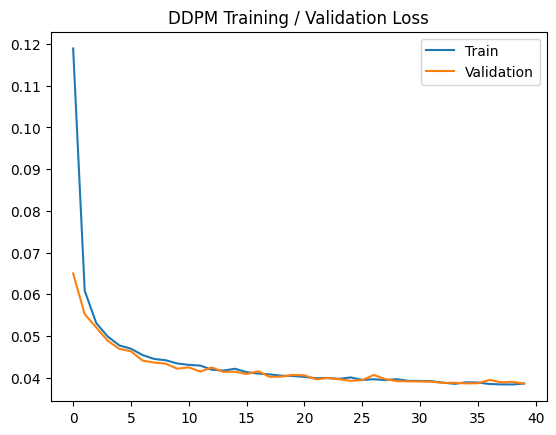

Generated 10 images in 1.2917 sec


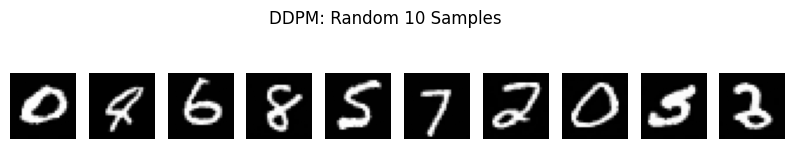

SSIM (DDPM, NN-ref): 0.6793
PSNR (DDPM, NN-ref): 14.34 dB
MS-SSIM (similarity): 0.1827 | Diversity (1 - MS-SSIM): 0.8173


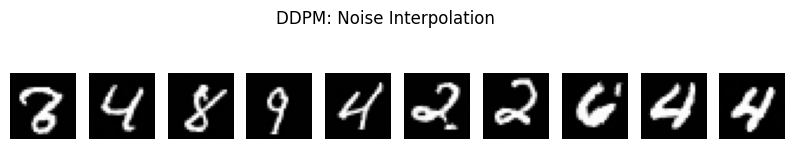

In [20]:
total_time = time.time() - total_start
print(f"Total Training Time: {total_time:.2f}s | Avg/Epoch: {total_time/epoch:.2f}s")

# 載入最佳模型
model.load_state_dict(torch.load(best_model_path, map_location=device))
model.eval()

# Loss 曲線
plt.figure()
plt.plot(train_losses, label="Train"); plt.plot(valid_losses, label="Validation")
plt.legend(); plt.title("DDPM Training / Validation Loss"); plt.show()

# 取樣（Reverse：p_sample 與 sampling loop）
@torch.no_grad()
def p_sample(x, t, t_index):
    bet = extract(betas, t, x.shape)
    sqrt_one_minus_ac = extract(sqrt_one_minus_alphas_cumprod, t, x.shape)
    sqrt_rec_a = extract(sqrt_recip_alphas, t, x.shape)
    # 估計 epsilon
    eps_theta = model(x, t)
    # 均值
    mean = sqrt_rec_a * (x - bet / sqrt_one_minus_ac * eps_theta)
    if t_index == 0:
        return mean
    var = extract(posterior_variance, t, x.shape)
    noise = torch.randn_like(x)
    return mean + torch.sqrt(var) * noise

@torch.no_grad()
def p_sample_loop(n_samples, img_size=28):
    x = torch.randn(n_samples, 1, img_size, img_size, device=device)
    for i in reversed(range(0, T)):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long)
        x = p_sample(x, t, i)
    return x  # [-1,1]

# 隨機生成 10 張
start_gen = time.time()
samples = p_sample_loop(10, img_size)
end_gen = time.time()
print(f"Generated 10 images in {end_gen - start_gen:.4f} sec")
samples_show = (samples + 1)/2  # -> [0,1]
plt.figure(figsize=(10,2))
for i in range(10):
    plt.subplot(1,10,i+1); plt.imshow(samples_show[i,0].cpu(), cmap="gray"); plt.axis("off")
plt.suptitle("DDPM: Random 10 Samples"); plt.show()

# 清晰度
def collect_test_images_01(dataloader, limit=None):
    xs = []
    for x, _ in dataloader:
        xs.append((x + 1)/2)  # [-1,1] -> [0,1]
        if limit is not None and sum(t.size(0) for t in xs) >= limit:
            break
    x = torch.cat(xs, dim=0)
    if limit is not None: x = x[:limit]
    return x  # [N,1,28,28]

with torch.no_grad():
    N_fake = 500
    fake = p_sample_loop(N_fake, img_size)     # [-1,1]
    fake_01 = (fake + 1)/2                     # [0,1]
    real_all_01 = collect_test_images_01(test_loader).to(device)

    fake_flat = fake_01.view(N_fake, -1)
    real_flat = real_all_01.view(real_all_01.size(0), -1)

    def chunk_min_mse_indices(A, B, chunk=200):
        mins = []
        for i in range(0, A.size(0), chunk):
            Ai = A[i:i+chunk]
            Ai2 = (Ai**2).sum(dim=1, keepdim=True); B2 = (B**2).sum(dim=1, keepdim=True).T
            AB = Ai @ B.T; dist2 = Ai2 + B2 - 2*AB
            idx = dist2.argmin(dim=1); mins.append(idx)
        return torch.cat(mins, dim=0)

    nn_idx = chunk_min_mse_indices(fake_flat, real_flat, chunk=200)

    ssim_list, psnr_list = [], []
    fake_np = fake_01.detach().cpu().numpy()
    real_np = real_all_01[nn_idx].detach().cpu().numpy()
    for i in range(N_fake):
        f = fake_np[i,0]; r = real_np[i,0]
        ssim_list.append(ssim(r, f, data_range=1.0))
        psnr_list.append(psnr(r, f, data_range=1.0))
    print(f"SSIM (DDPM, NN-ref): {np.mean(ssim_list):.4f}")
    print(f"PSNR (DDPM, NN-ref): {np.mean(psnr_list):.2f} dB")

# 穩定性
ms_ssim_metric = MultiScaleStructuralSimilarityIndexMeasure(
    data_range=1.0, betas=(0.0448, 0.2856, 0.3001), kernel_size=(7,7)
).to(device)
with torch.no_grad():
    A = (p_sample_loop(64, img_size) + 1)/2  # [0,1]
    B = (p_sample_loop(64, img_size) + 1)/2
    ms_val = ms_ssim_metric(A, B).item()
diversity = 1.0 - ms_val
print(f"MS-SSIM (similarity): {ms_val:.4f} | Diversity (1 - MS-SSIM): {diversity:.4f}")

# 可控性
with torch.no_grad():
    n_steps = 10
    z1 = torch.randn(1, 1, img_size, img_size, device=device)
    z2 = torch.randn(1, 1, img_size, img_size, device=device)
    outs = []
    for a in np.linspace(0,1,n_steps):
        zt = (1-a)*z1 + a*z2
        x = zt.clone()
        # run reverse starting from interpolated noise
        for i in reversed(range(0, T)):
            t = torch.full((1,), i, device=device, dtype=torch.long)
            x = p_sample(x, t, i)
        outs.append(((x+1)/2).cpu())
    outs = torch.cat(outs, dim=0)
plt.figure(figsize=(10,2))
for i in range(n_steps):
    plt.subplot(1,10,i+1); plt.imshow(outs[i,0], cmap="gray"); plt.axis("off")
plt.suptitle("DDPM: Noise Interpolation"); plt.show()